In [1]:
library(caret)
library(pander)
library(doMC)
library(plyr)
library(dplyr)
library(Matrix)
library(data.table)
library(stringr)
library(AnomalyDetection)

# Register CPU core count
registerDoMC(cores=23)

# Utility function for use with % frequency tables
frqtab <- function(x, caption) {
    round(100*prop.table(table(x)), 3)
}

# Utility function to round values in a list
# but only if they are numeric

round_numeric <- function(lst, decimals=2) {
    lappy(lst, function(x){
        if (is.numeric(x)) {
            x <- round(x, decimals)
        }
        return(x)
    })
}

# Utility function for model comparison

summod <- function(cm, fit) {
    summ <- list(k = fit$finalModel$k,
                metric = fit$metric,
                value = fit$results[fit$resultes$k == fit$finalModel$k, fit$metric],
                TN = cm$table[1,1], # True negatives
                TP = cm$table[2,2], # True positives
                FN = cm$table[1,2], # False negatives
                FP = cm$table[2,1], # False positives
                acc = cm$overall["Accuracy"], 
                sens = cm$byClass["Sensitivity"],
                spec = cm$byClass["Specificity"],
                PPV = cm$byClass["Positive Predicted Value"],
                NPV = cm$byClass["Negative Prediced Value"])
    round_numeric(summ)
}

# Utility function to normalize the data

normalize <- function(x){
    num <- x - min(x)
    denom <- max(x) - min(x)
    return (num/denom)
}

#Function to timeslice the data however user would like

timeslice <- function(df, slice, interval) {
    if (slice == 'secs'){
        df <- subset(df, df$StartTime <= df$StartTime[1] + (interval))
        return(df)
    }
    else if (slice == 'mins'){
        df <- subset(df, df$StartTime <= df$StartTime[1] + (interval * 60))
        return(df)
    }
    else if (slice == 'hours') {
        df <- subset(df, df$StartTime <= df$StartTime[1] + (interval * 3600))
        return(df)
    }
    else if (slice == 'days'){
        df <- subset(df, df$StartTime <= df$StartTime[1] + (interval * 86400))
        return(df)
    }
    else
      error <- print("Please enter a valid time interval.")
      return(error)
}

Loading required package: lattice
Loading required package: ggplot2
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, last



In [ ]:
# Read .binetflow file into dataframe

#flowdata_csv <- read.csv("capture20110810.binetflow", colClasses = c("character", "numeric", "character", 
                                                                    #"character","character","character",
                                                                    #"character","character","character",
                                                                    #"character","character","numeric", 
                                                                    #"numeric", "numeric", "character"), 
                                                                    #strip.white = TRUE, sep = ',')

flowdata_csv <- fread("capture20110810.binetflow", colClasses = c("myPosixCt", "numeric", "character", 
                                                                  "character","character","character",
                                                                  "character","character","character",
                                                                  "character","character","numeric", 
                                                                  "numeric","numeric", "character"), 
                                                                  sep = 'auto')

# Set POSIX formatting for StartTime

options(set.seconds="6")
flowdata_csv$StartTime <- as.POSIXct(flowdata_csv$StartTime, format = "%Y/%m/%d %H:%M:%OS")
    
# Trim leading and trailing whitespace

str(flowdata_csv)

Read 2824636 rows and 15 (of 15) columns from 0.360 GB file in 00:00:14


## Twitter AnomalyDetection Package

Recently Twitter OpenSourced an internal library, written in R, that can be used to discovery anomalies within time series data. The inherent time series nature of NetFlow data will allow us to use this library to potentially discover anomalies that may exist within the dataset.

https://github.com/twitter/AnomalyDetection

This package uses an algorithm called Seasonal Hybrid ESD, which builds upon Generalized ESD. This implementation is built to detect both local and global anomalies that may exist within a given dataset.

### Generalized Extreme Studentized Deviate (ESD)

Generalized ESD is an algorithm that was developed to detect one or more outliers in a univariate data set that follows an approximately normal distribution.

When working with Generalized ESD, we must specify an "upper bound" of anomalies within a given dataset.

Given this upper bound, $r$, the algorithm essentially performs $r$ seperate tests : a test for one outlier, a test for two outliers, and so on up to $r$ outliers.

This can be seen as :

$$ R_{i} = \frac{\max_{i}|x_{i}-\bar x|}{s} $$

with $x$ and $s$ denoting the sample mean and sample standard deviation, respectively.

This will remove the observation that maximizes $|x_{i}-\bar x|$ and then recompute the above statistic with $n-1$ observations, repeating the process until $r$ observations have been removed. This results in the $r$ statistics $R_{1}, R_{2},...,R_{r}$.

$$ Region : \lambda_{i} = \frac{(n-i) \, t_{p, \, n-i-1}}{\sqrt{(n-i-1+t_{p, \, n-i-1}^{2}) (n-i+1)}}\hspace{.2in} i = 1, 2, \ldots, r$$

where $t_{p,v}$ is the $100p$ percentage point from the t-distribution with $v$ degrees of freedom and 

$$ p = 1 - \frac{a}{2(n-i+1)} $$

The number of outliers is determined by findings the largest $i$ such that $R_{i} > \lambda_{i}$.

### Seasonal-Hybrid-ESD

This is a combination of algorithms that revolve around the idea that there is seasonality that exists within data that we're looking at. This seasonality can prove challenging when trying to find anomalies in a given dataset that may not look like anomalies from a global perspective, with respect to the data. Seasonality introduces a concept similar to windowing data and trying to spoint local anomalies in a given window (season) that may have been overlooked from a global perspective.

####<font color='red'>TODO</font> : 
<font color='red'>* Add elementwise breakdown of each ESD Algorithm to flow data</font>

In [ ]:
# Subset and normalize data

#Function to carve up by timeslice / interval

#flowdata_slice <- timeslice(flowdata_csv, 'mins', 10)

labels <- c("Label")

tot_pkts <- c("TotPkts")
duration <- c("Dur")
tot_bytes <- c("TotBytes")
src_bytes <- c("SrcBytes")


flowdata_tot_pkts <- subset(flowdata_csv, select = c(tot_pkts))
flowdata_duration <- subset(flowdata_csv, select = c(duration))
flowdata_tot_bytes <- subset(flowdata_csv, select = c(tot_bytes))
flowdata_src_bytes <- subset(flowdata_csv, select = c(src_bytes))

#flowdata_slice <- subset(flowdata_csv, select = c(cont_vars, labels))

#flowdata_slice <- sample_n(flowdata_slice, 50000)

In [23]:
res_src_bytes = AnomalyDetectionVec(flowdata_src_bytes[1:40000], max_anoms = .0009, plot=TRUE, period = 360)
res_tot_pkts = AnomalyDetectionVec(flowdata_tot_pkts[1:40000], max_anoms = .0009, plot=TRUE, period = 360)
res_tot_bytes = AnomalyDetectionVec(flowdata_tot_bytes[1:40000], max_anoms = .0009, plot=TRUE, period = 360)
res_dur = AnomalyDetectionVec(flowdata_duration[1:40000], max_anoms = .0009, plot=TRUE, period = 360)

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[2]]) result is length 0


$anoms
   index     anoms
1    114  60214264
2    117   2625276
3    124 132816366
4    137  10056796
5    178  15514984
6    208  60363789
7    320  60334389
8    334  10742562
9    335   1641273
10   380      6702
11   740      3709
12   856    490219
13   905   1221380
14  1043    484680
15  1159   8272222
16  1341    644557
17  1503  68636560
18  1630 248405120
19  1786   1763343
20  2180      1658
21  2900      1609
22  4163   6258540
23  4842   1543732
24  6860      6246
25 10460      1655
26 11900     33559
27 15500      1612
28 15529    761923
29 21260      1643
30 22578    508178
31 26300      3898
32 29839   2231518
33 34580      3085
34 34858   1002946
35 37460     12543
36 39620      1780

$plot


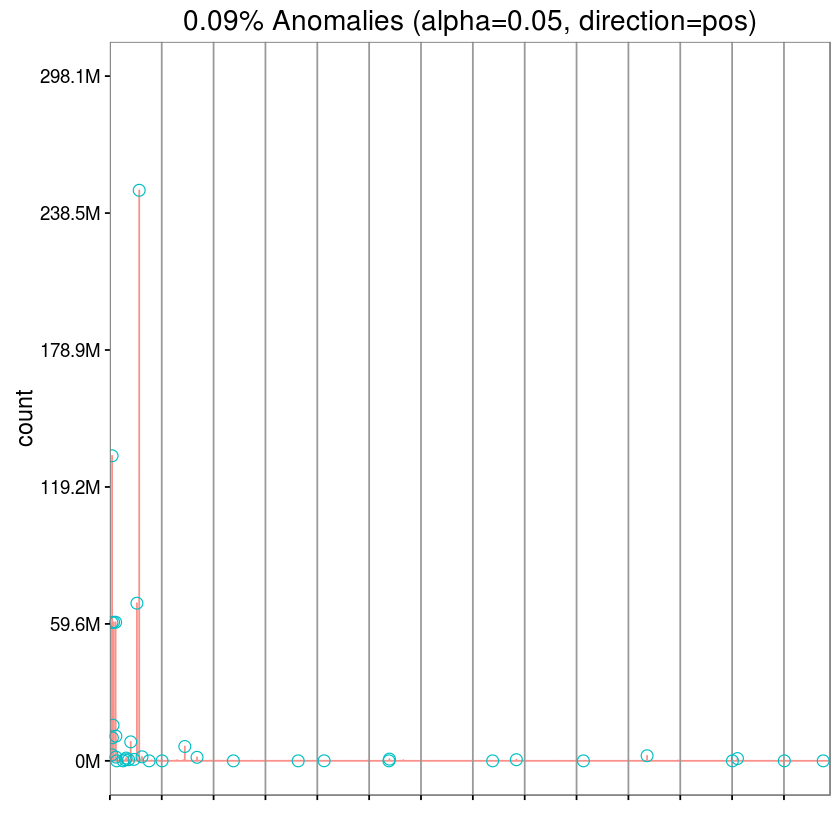

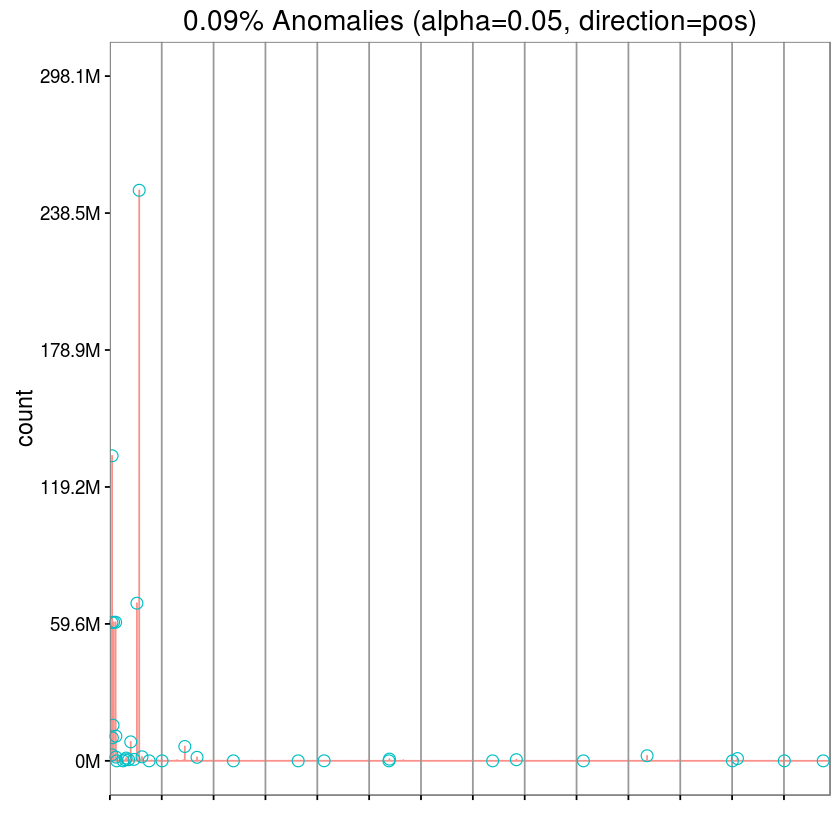

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[2]]) result is length 0


$anoms
   index  anoms
1    114  72157
2    121   4360
3    124 162760
4    137  23574
5    166   8223
6    174   4036
7    178  19678
8    179   3851
9    208  51576
10   320  55068
11   334  12441
12   851   3955
13   905   5518
14   906   3697
15  1096   3380
16  1159   7146
17  1244   6552
18  1503 105555
19  1630 214827
20  1633   3818
21  1674   3463
22  1786   3245
23  2330   5957
24  2610   3295
25  2703   4089
26  2899   5344
27  4163   6754
28  7946   3753
29 10203   3967
30 14334   3537
31 15529  89918
32 15646   5322
33 22578   5270
34 29839  26148
35 31550   7164
36 34858  10557

$plot


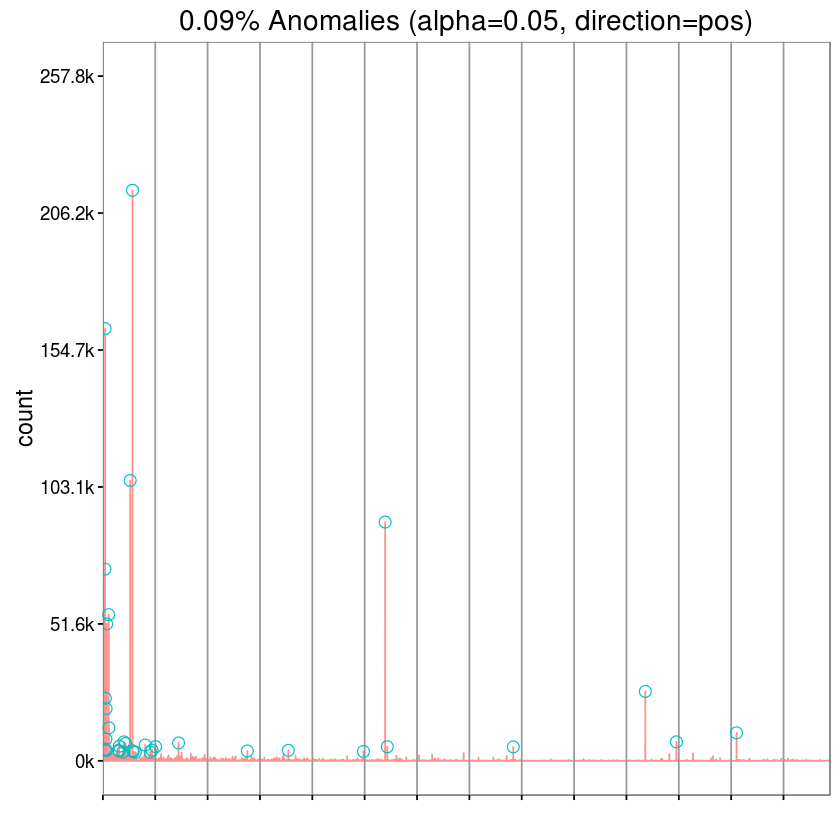

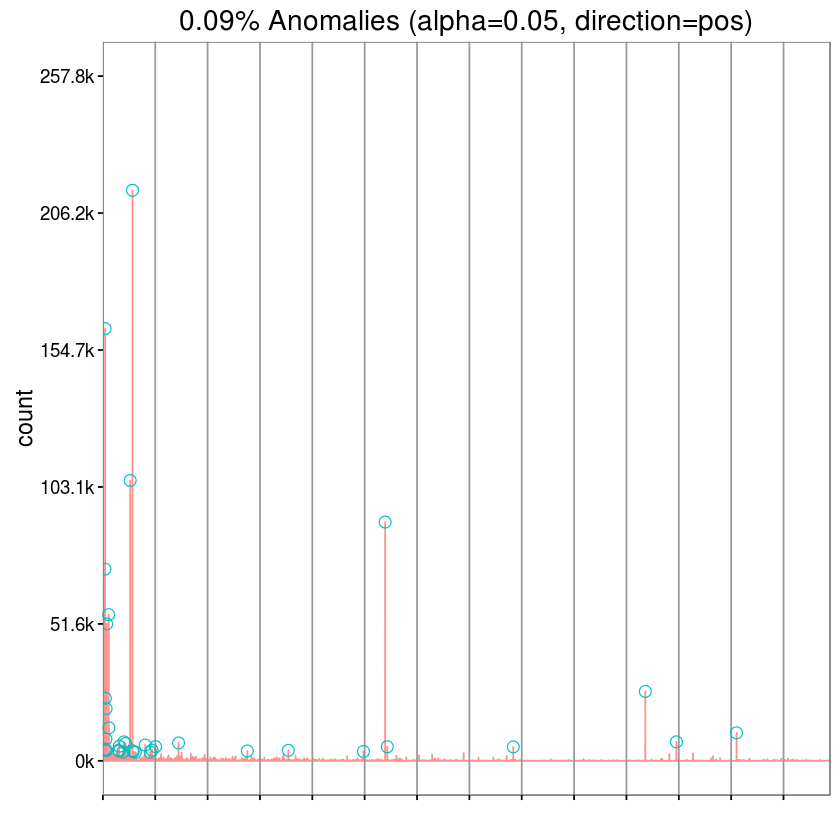

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[2]]) result is length 0


$anoms
   index     anoms
1    114  61638544
2    117   2636496
3    124 137136528
4    137  10855048
5    178  15918352
6    208  60964440
7    320  61164753
8    334  10742562
9    335   1641273
10   431   1199483
11   491   1680543
12   851   1956274
13   905   2836172
14  1159   8272222
15  1503  70963308
16  1630 248405120
17  1786   1965836
18  4163   6423280
19  4336   1509452
20  4842   1612718
21  5920   1713533
22  7246   1342476
23  7946   3373406
24  8326   1419870
25  9406   1196600
26 10203   5455500
27 15529 117408698
28 15646   5921401
29 19850   3278650
30 20663   1148463
31 29839   2231518
32 31158   2471451
33 31550   5762062
34 32460   3708409
35 33562   1266664
36 34858   5542950

$plot


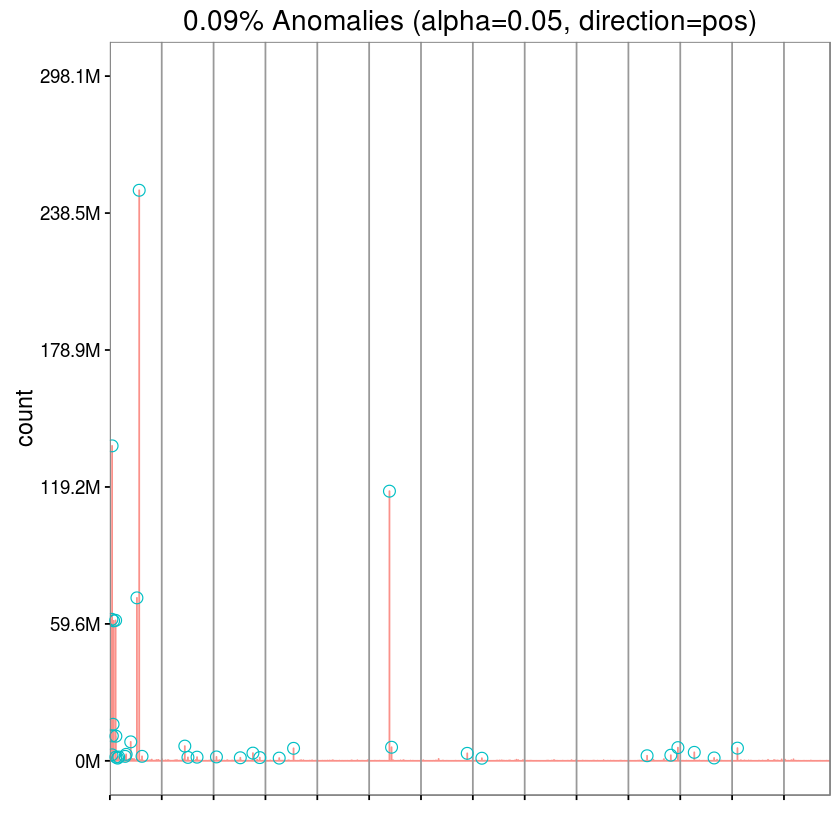

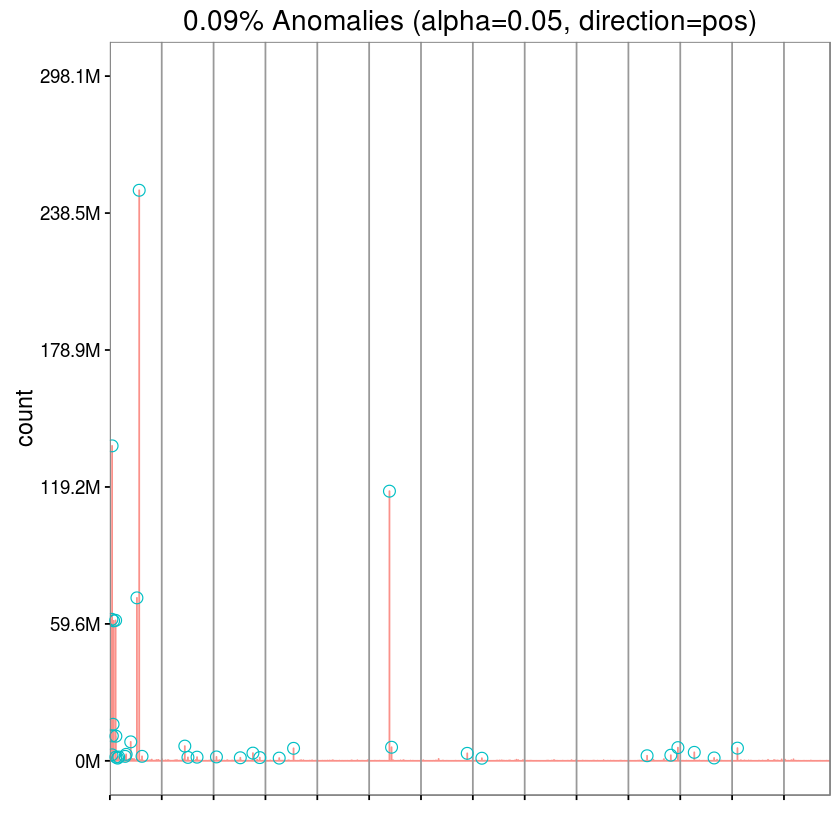

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[2]]) result is length 0


$anoms
   index    anoms
1    173 3586.684
2   2242 3589.830
3   2332 3572.449
4   3327 3590.352
5   4281 3583.495
6   4358 3590.978
7   4762 3593.849
8   5305 3574.314
9   5387 3582.922
10  5847 3516.128
11  6292 3578.716
12  7472 3582.245
13  9321 3552.999
14  9368 3578.310
15 10041 3593.019
16 10527 3589.896
17 10894 3597.562
18 11607 3595.928
19 12638 3596.885
20 13667 3595.501
21 14721 3505.597
22 14854 3557.317
23 15898 3590.991
24 20967 3514.488
25 23361 3595.194
26 24207 3579.713
27 24442 3467.062
28 25831 3599.426
29 27082 3442.026
30 28162 3475.203
31 28522 3599.992
32 29507 3593.664
33 32078 3565.030
34 34618 3596.056
35 37882 3537.086
36 39682 3457.041

$plot


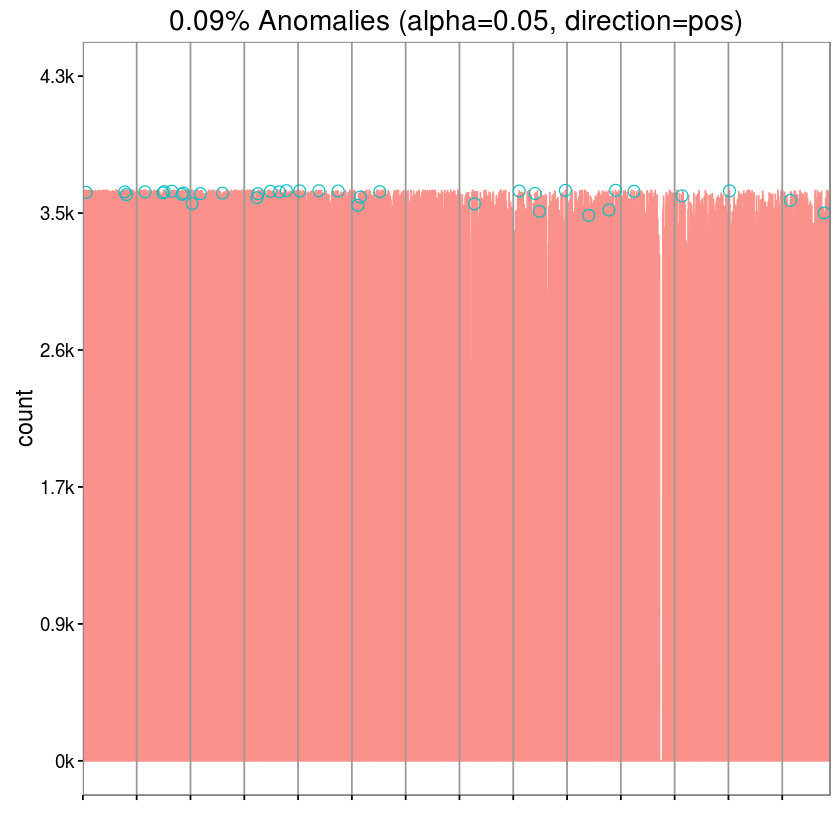

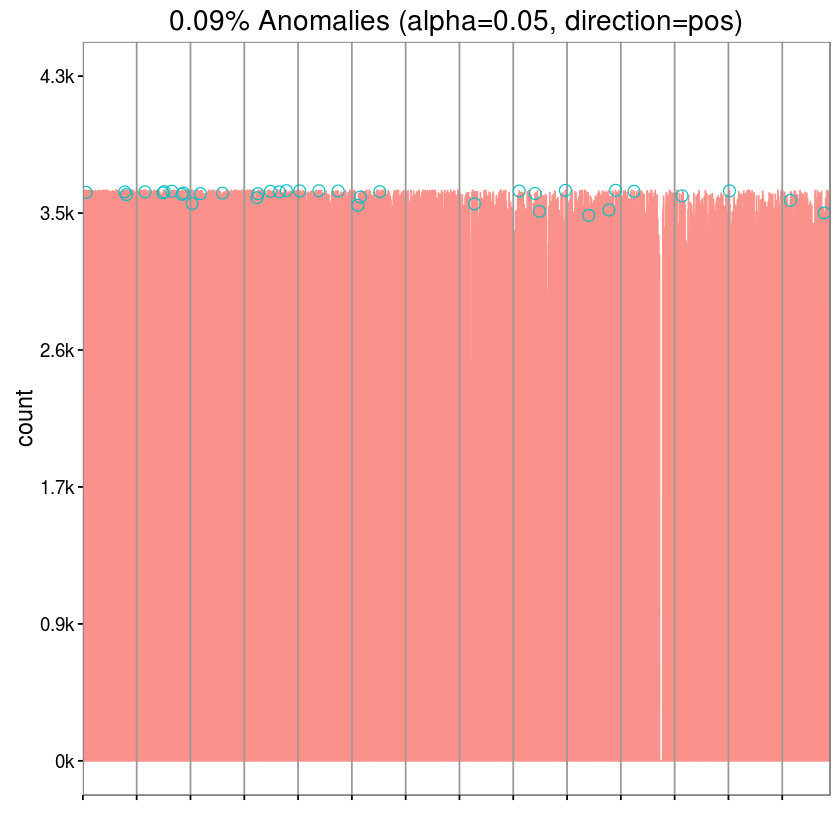

In [24]:
res_src_bytes
res_tot_pkts
res_tot_bytes
re

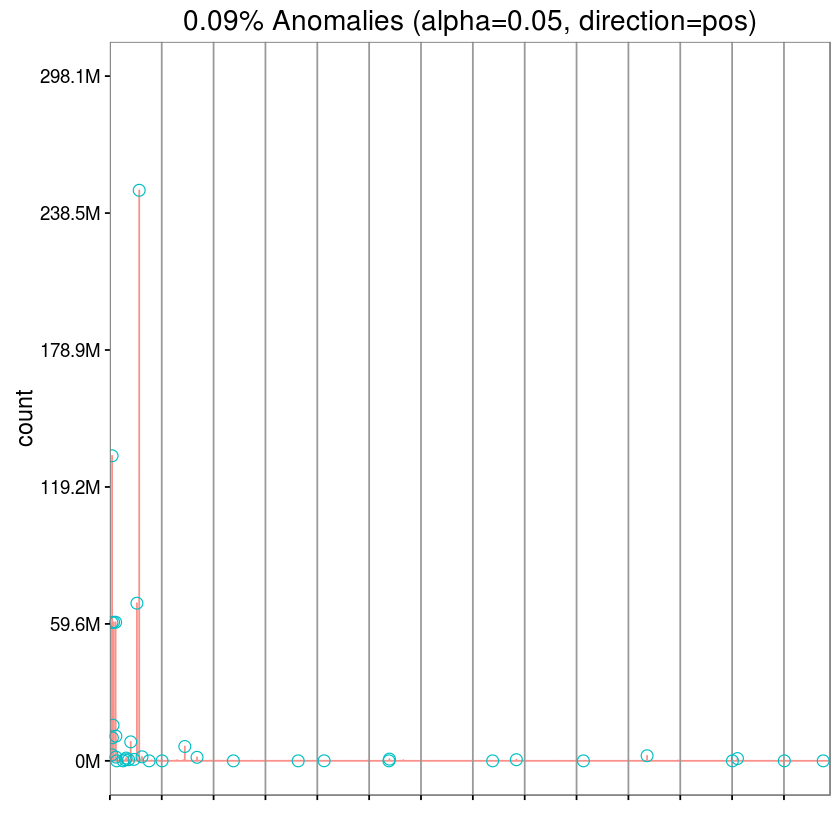

In [22]:
res$plot

In [42]:
# Normalize the data

#flowdata_slice <- flowdata_slice %>% mutate_each_(funs(normalize), vars = cont_vars)

# Clean flowdata_conts, totally hacky but dataframe transforms are crazy fast and scale well

flowdata_slice <- flowdata_slice[!(flowdata_slice$Dur == 0),]
flowdata_slice <- flowdata_slice[!(flowdata_slice$TotPkts == 0),]
flowdata_slice <- flowdata_slice[!(flowdata_slice$TotBytes == 0),]
flowdata_slice <- flowdata_slice[!(flowdata_slice$SrcBytes == 0),]

# Log normalize

#flowdata_slice[,cont_vars] <- log(flowdata_slice[,cont_vars])

# Re-factor-fy variable

flowdata_slice$Label <- as.factor(flowdata_slice$Label)

str(flowdata_slice)

ERROR: Error in eval(expr, envir, enclos): object 'flowdata_slice' not found


ERROR: Error in eval(expr, envir, enclos): object 'flowdata_slice' not found


ERROR: Error in eval(expr, envir, enclos): object 'flowdata_slice' not found


ERROR: Error in eval(expr, envir, enclos): object 'flowdata_slice' not found


ERROR: Error in is.factor(x): object 'flowdata_slice' not found


ERROR: Error in str(flowdata_slice): object 'flowdata_slice' not found


In [14]:
head(raw_data, n=10)

timestamp   count
1  1980-09-25 14:01:00 182.478
2  1980-09-25 14:02:00 176.231
3  1980-09-25 14:03:00 183.917
4  1980-09-25 14:04:00 177.798
5  1980-09-25 14:05:00 165.469
6  1980-09-25 14:06:00 181.878
7  1980-09-25 14:07:00 184.502
8  1980-09-25 14:08:00 183.303
9  1980-09-25 14:09:00 177.578
10 1980-09-25 14:10:00 171.641

## References

[1] Generalized ESD Test for Outliers http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm